In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import math


In [ ]:
# --- 1. ALGORITMOS ---

def greedy_mlst(G):
    """
    Algoritmo Greedy Constructivo:
    """
    # Elegir raíz (nodo con mayor grado)
    degrees = dict(G.degree())
    root = max(degrees, key=degrees.get)
    
    tree_edges = []
    visited = {root}
    # Frontera: lista de (nodo_en_arbol, vecino_fuera)
    # Priorizamos vecinos que tengan alto grado para fomentar ramificación
    frontier = []
    
    for n in G.neighbors(root):
        frontier.append((root, n))
        
    while len(visited) < len(G.nodes()):
        # Heurística: Elegir de la frontera el nodo destino con mayor grado
        # para intentar convertirlo en interno y ramificar.
        if not frontier: break 
        
        # Ordenar frontera por grado del destino (descendente)
        frontier.sort(key=lambda x: G.degree(x[1]), reverse=True)
        
        u, v = frontier.pop(0) # Mejor opción
        
        if v not in visited:
            visited.add(v)
            tree_edges.append((u, v))
            # Añadir nuevos vecinos a la frontera
            for w in G.neighbors(v):
                if w not in visited:
                    frontier.append((v, w))
    
    T = nx.Graph()
    T.add_nodes_from(G.nodes())
    T.add_edges_from(tree_edges)
    return T


def count_leaves(T):
    return sum(1 for n in T.nodes() if T.degree(n) == 1)

def local_search_mlst(G, initial_T, max_iter=1000):
    """
    Búsqueda Local (Best Improvement):

    """
    current_T = initial_T.copy()
    current_leaves = count_leaves(current_T)
    
    improved = True
    iteration = 0
    
    while improved and iteration < max_iter:
        improved = False
        iteration += 1
        
        # Obtener aristas que NO están en el árbol (candidatas a entrar)
        non_tree_edges = list(set(G.edges()) - set(current_T.edges()))
        
        best_swap = None
        best_leaf_gain = 0
        
        # Evaluar vecindario (Swaps)
        # Nota: Para optimizar tiempo en grafos grandes, podríamos evaluar solo una muestra
        for u, v in non_tree_edges:
            # Al añadir (u,v) se crea un ciclo. Encontramos el camino en el árbol.
            try:
                path = nx.shortest_path(current_T, u, v)
                # El ciclo está formado por el path + la arista (u,v)
                # Intentamos quitar cada arista del path para romper el ciclo
                for i in range(len(path) - 1):
                    x, y = path[i], path[i+1]
                    
                    # Simular Swap
                    current_T.add_edge(u, v)
                    current_T.remove_edge(x, y)
                    
                    new_leaves = count_leaves(current_T)
                    gain = new_leaves - current_leaves
                    
                    if gain > best_leaf_gain:
                        best_leaf_gain = gain
                        best_swap = ((u, v), (x, y)) # (in, out)
                    
                    # Revertir Swap
                    current_T.add_edge(x, y)
                    current_T.remove_edge(u, v)
                    
            except nx.NetworkXNoPath:
                continue

        # Aplicar el mejor movimiento si mejora
        if best_swap:
            e_in, e_out = best_swap
            current_T.add_edge(*e_in)
            current_T.remove_edge(*e_out)
            current_leaves += best_leaf_gain
            improved = True
            
    return current_T


In [60]:
def generate_experiments2():
    experiments = []
    
    # Tamaños solicitados
    sizes = [100, 200, 300, 400, 500]
    
    for n in sizes:
        print(f"Generando grafo aleatorio de {n} nodos...")
        
        # Calculamos p para que el grafo sea conexo pero disperso.
        # El umbral de conectividad es ln(n)/n. Multiplicamos por 3 para asegurar margen.
        p = (3 * math.log(n)) / n
        
        G = nx.erdos_renyi_graph(n, p)
        
        # Asegurar que sea conexo (si no, regenerar)
        while not nx.is_connected(G):
            G = nx.erdos_renyi_graph(n, p)
            
        experiments.append((f"Aleatorio ({n})", G))
    
    return experiments

In [61]:
def run_experiments2():
    test_cases = generate_experiments2()
    
    names = []
    greedy_leaves = []
    ls_leaves = []
    times_greedy = []
    times_ls = []
    
    print(f"{'Caso':<20} | {'Hojas Greedy':<12} | {'Hojas LS':<10} | {'Mejora':<8}")
    print("-" * 60)
    
    for name, G in test_cases:
        # Ejecutar Greedy
        start = time.time()
        T_greedy = greedy_mlst(G)
        time_g = time.time() - start
        l_greedy = count_leaves(T_greedy)
        
        # Ejecutar Búsqueda Local (usando la salida del Greedy como inicial)
        start = time.time()
        T_ls = local_search_mlst(G, T_greedy)
        time_ls = time.time() - start + time_g # Sumamos el tiempo del greedy porque es el pre-proceso
        l_ls = count_leaves(T_ls)
        
        names.append(name)
        greedy_leaves.append(l_greedy)
        ls_leaves.append(l_ls)
        times_greedy.append(time_g)
        times_ls.append(time_ls)
        
        mejora = l_ls - l_greedy
        print(f"{name:<20} | {l_greedy:<12} | {l_ls:<10} | +{mejora}")

    # --- GRÁFICOS ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico 1: Calidad (Número de hojas)
    x = range(len(names))
    width = 0.35
    ax[0].bar([i - width/2 for i in x], greedy_leaves, width, label='Greedy', color='#a0c4ff')
    ax[0].bar([i + width/2 for i in x], ls_leaves, width, label='Búsqueda Local', color='#90EE90')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(names, rotation=45)
    ax[0].set_ylabel('Número de Hojas')
    ax[0].set_title('Comparación de Calidad (Más hojas es mejor)')
    ax[0].legend()
    
    # Gráfico 2: Tiempo de Ejecución
    ax[1].plot(names, times_greedy, marker='o', label='Greedy', color='blue')
    ax[1].plot(names, times_ls, marker='s', label='Búsqueda Local', color='green')
    ax[1].set_ylabel('Tiempo (segundos)')
    ax[1].set_title('Comparación de Tiempo (Menos es mejor)')
    ax[1].set_xticklabels(names, rotation=45)
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Generando grafo aleatorio de 100 nodos...
Generando grafo aleatorio de 200 nodos...
Generando grafo aleatorio de 300 nodos...
Generando grafo aleatorio de 400 nodos...
Generando grafo aleatorio de 500 nodos...
Caso                 | Hojas Greedy | Hojas LS   | Mejora  
------------------------------------------------------------
Aleatorio (100)      | 82           | 84         | +2
Aleatorio (200)      | 166          | 170        | +4
Aleatorio (300)      | 252          | 257        | +5
Aleatorio (400)      | 338          | 344        | +6
Aleatorio (500)      | 428          | 436        | +8


/tmp/ipykernel_1887/2723848239.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(names, rotation=45)


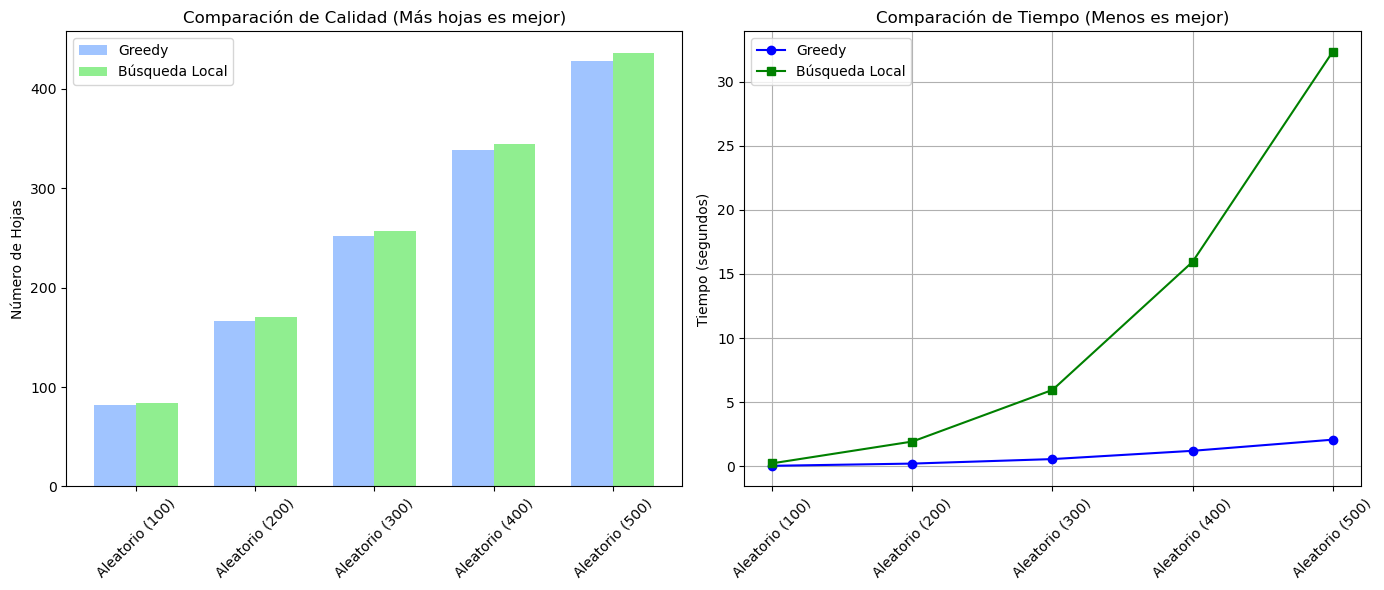

In [63]:
run_experiments2()